In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.colors as mcolors
import matplotlib.path as mpath
from matplotlib.ticker import MaxNLocator
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

In [2]:
def load_trend_data(variable, model, experiment, period):
    #loads in the trend data
    #factor to convert trend data from Pa/year to hPa
    conversion_factor = 1.65
    
    #slice trend to the N. Atlantic
    lat_range = slice(20, 80)
    lon_range = slice(-90, 40)
    
    filepath = f"{base_dir}/trend_calc_LESFMIP/linear_regression/NAO/{experiment}/{model}/psl_mon_{experiment}_{model}_DJF_linear_trend_{period}_stats.nc"
    return xr.open_dataset(filepath).sel(lat=lat_range, lon=lon_range) * conversion_factor

def get_min_max(data_dict, variable):
    #finds the max and min values of the data
    values_min = [np.min(data[variable]) for data in data_dict.values()]
    values_max = [np.max(data[variable]) for data in data_dict.values()]
    return min(values_min), max(values_max)



In [5]:
# Define the model name and path template
models = ['HadGEM3-GC31-LL','CanESM5','MIROC6','MPI-ESM1-2-LR']
base_dir = '/gws/nopw/j04/extant/users/slbennie'

period = '1850-2015'
period_title = '1850-2014'

# List of forcing experiments
experiments = ['historical', 'hist-aer', 'hist-GHG', 'hist-sol', 'hist-totalO3', 'hist-volc']
trend_data = {}
all_trend_values = []

for m in models:
    trend_data[m] = {}
    for e in experiments:
        # Load trend data
        trend_data[m][e] = load_trend_data('psl', m, e, period)
        all_trend_values.append(trend_data[m][e]['slope'].values.flatten())


# After loading all experiments for a model, add the 'sum' entry
for m in models:
    experiments_to_sum = [e for e in experiments if e != 'historical']

    # Copy structure from one of the existing experiments
    sum_data = trend_data[m][experiments_to_sum[0]].copy(deep=True)
    
    # Sum the 'slope' values across experiments
    slope_sum = sum([trend_data[m][e]['slope'] for e in experiments_to_sum])
    sum_data['slope'] = slope_sum
    
    # Add to trend_data dictionary
    trend_data[m]['sum'] = sum_data

# Add 'sum' values to plotting list
for m in models:
    all_trend_values.append(trend_data[m]['sum']['slope'].values.flatten())

#reckon you add in another sum column and then plot that.
print(trend_data['HadGEM3-GC31-LL']['historical'])

# Concatenate into a single array
all_trend_values = np.concatenate(all_trend_values)
all_trend_values = all_trend_values[~np.isnan(all_trend_values)]  # Remove NaNs

# Compute min and max
min_trend = np.min(all_trend_values)
max_trend = np.max(all_trend_values)

# Color normalization
norm_all = mcolors.TwoSlopeNorm(vmin=-max_trend, vcenter=0, vmax=max_trend)

print(min_trend, max_trend)

<xarray.Dataset> Size: 54kB
Dimensions:         (lat: 25, lon: 53)
Coordinates:
  * lat             (lat) float64 200B 20.0 22.5 25.0 27.5 ... 75.0 77.5 80.0
  * lon             (lon) float64 424B -90.0 -87.5 -85.0 ... 35.0 37.5 40.0
Data variables:
    slope           (lat, lon) float64 11kB 0.2419 0.217 ... 0.2382 0.2809
    intercept       (lat, lon) float64 11kB 1.676e+05 1.676e+05 ... 1.676e+05
    p_value         (lat, lon) float64 11kB 1.501e-08 8.256e-08 ... 0.3239
    slope_CI_lower  (lat, lon) float64 11kB 0.163 0.142 ... -0.1814 -0.1466
    slope_CI_upper  (lat, lon) float64 11kB 0.3207 0.2919 0.28 ... 0.6579 0.7084
-5.053668874920146 5.487994857847356


/tmp/ipykernel_1585/2774153875.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0,0,0.91,0.97])


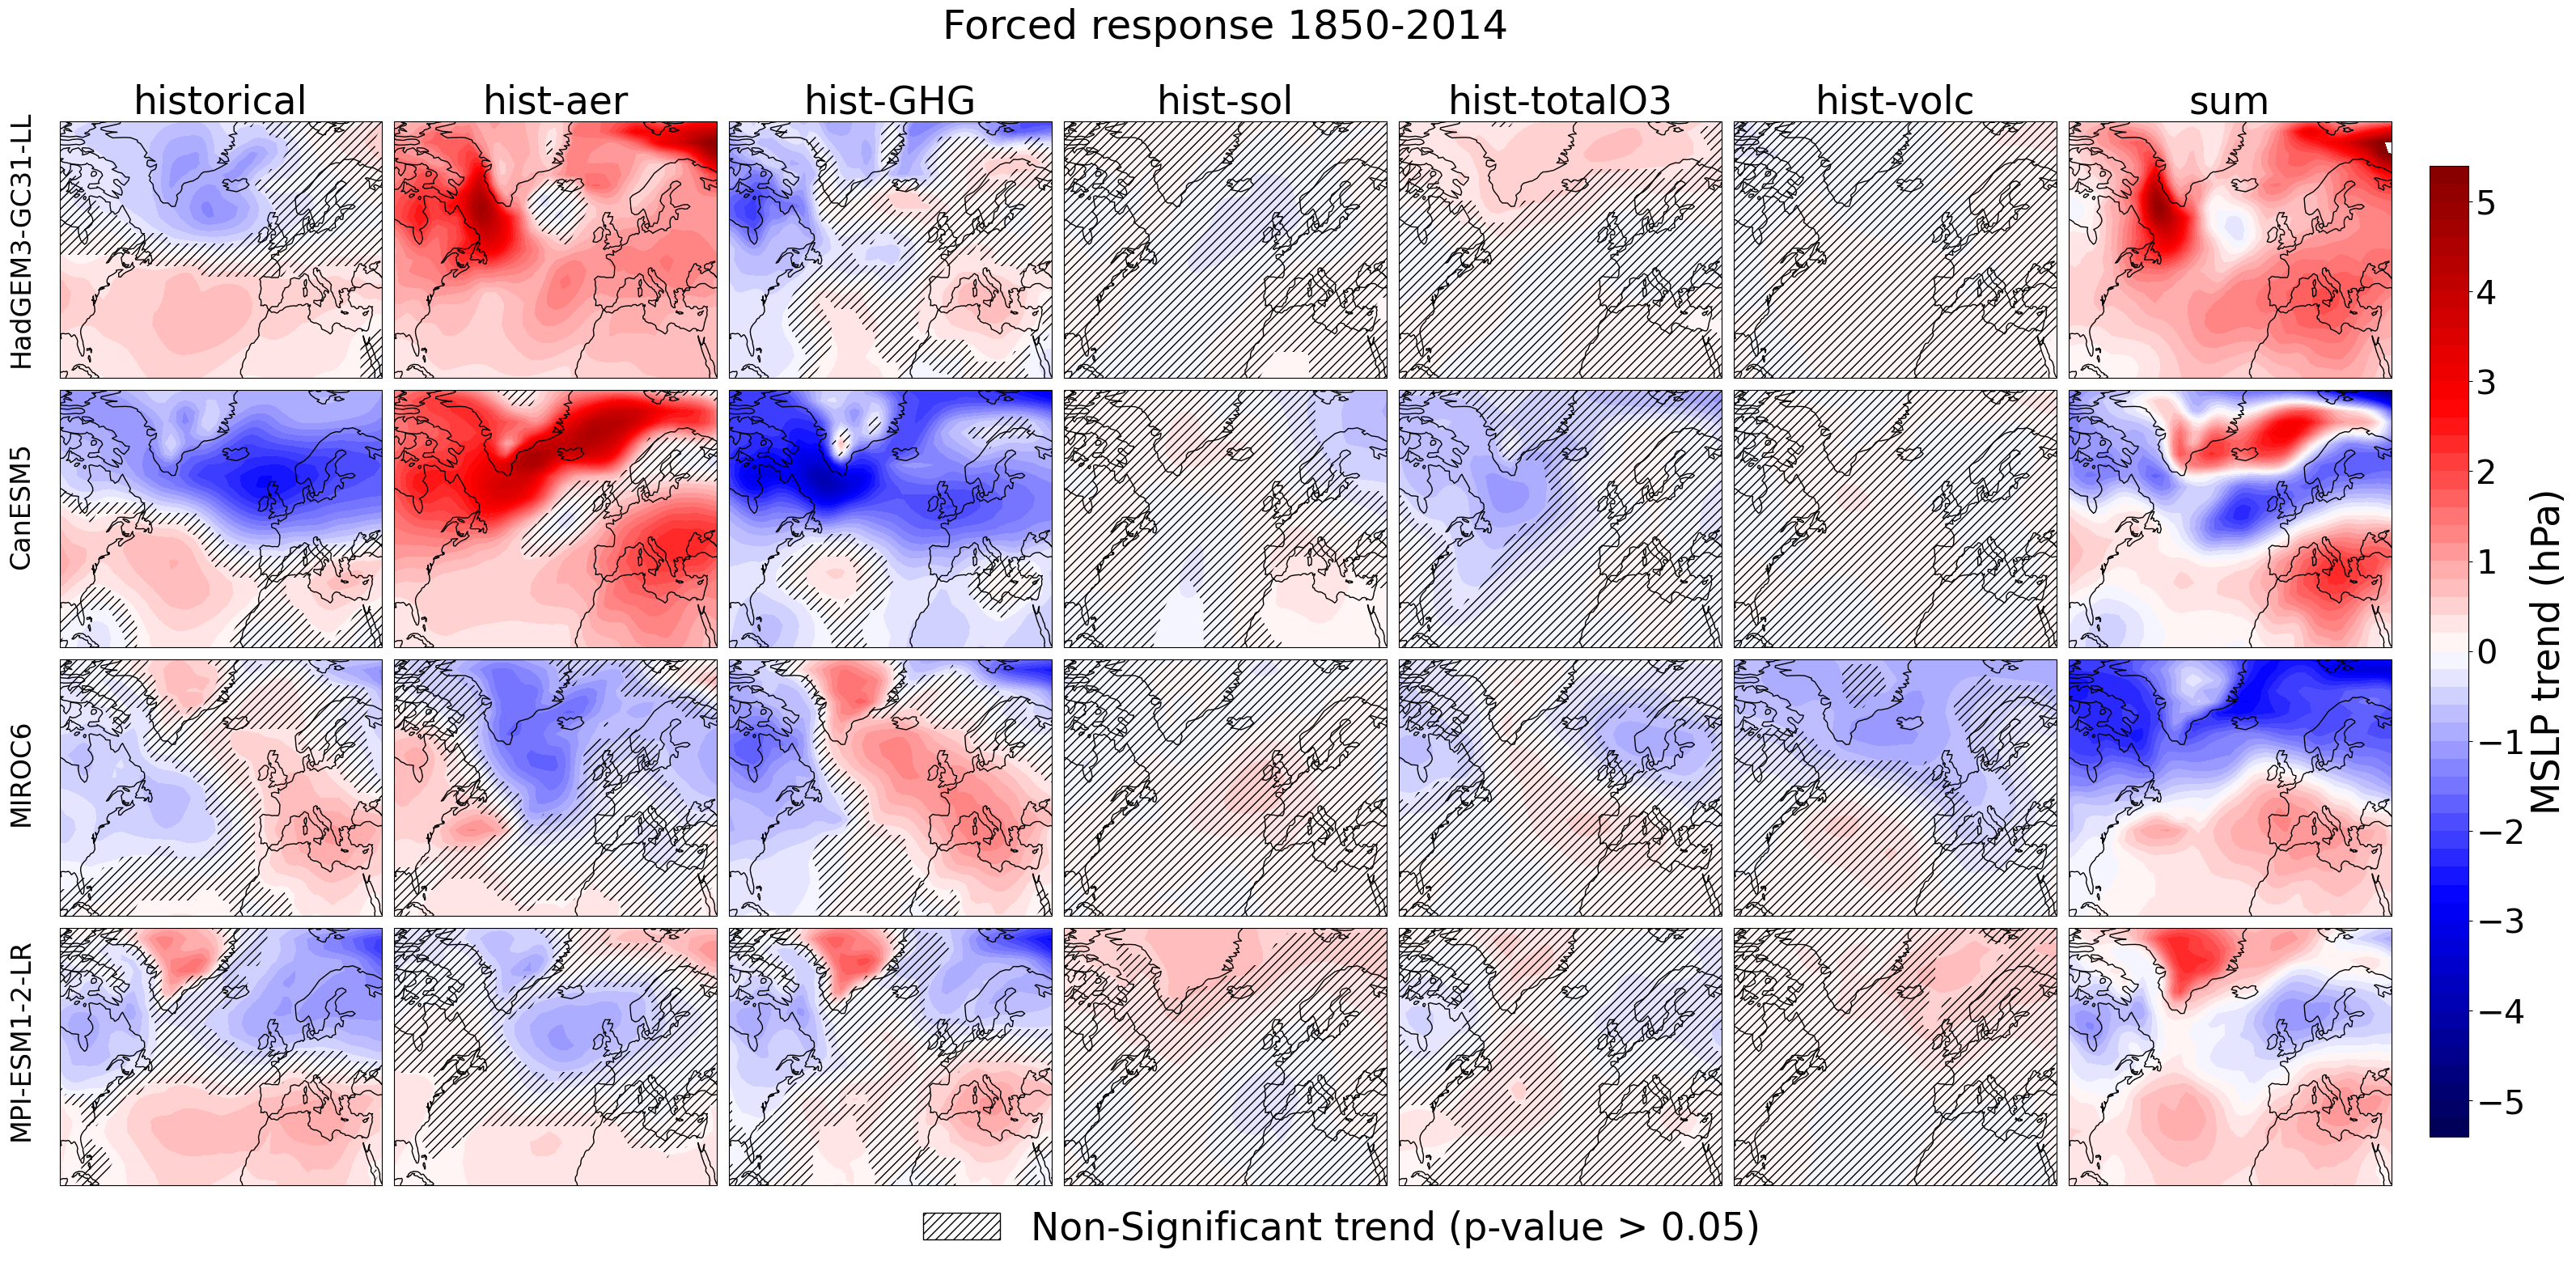

In [7]:
#PLOTTING - trend figure
models = ['HadGEM3-GC31-LL','CanESM5','MIROC6','MPI-ESM1-2-LR']
experiments = ['historical', 'hist-aer', 'hist-GHG', 'hist-sol', 'hist-totalO3', 'hist-volc', 'sum']

fig, ax = plt.subplots(nrows=4, ncols=7, figsize=(32,15), subplot_kw={'projection': ccrs.PlateCarree()})
cmap = 'seismic'

#re-updating manually based on the max and mins.
#norm_all = mcolors.TwoSlopeNorm(vmin=-5.5, vcenter=0, vmax=5.5)

levels = np.arange(-5.4,5.6,0.2)

# Map extent
lon_min, lon_max = -90, 40
lat_min, lat_max = 20, 80

# Plotting each row and column

for i, m in enumerate(models):
    for j, e in enumerate(experiments):
        data = trend_data[m][e]
        contour = ax[i, j].contourf(data['lon'], data['lat'], data['slope'], cmap=cmap, levels=levels, norm=norm_all)
        mask = data['p_value'] > 0.05
        if j<6:
            ax[i,j].contourf(data['lon'], data['lat'], mask, levels=[0.5,1], colors='none', hatches=['///'], transform=ccrs.PlateCarree(), alpha=0)
        if i==0:
            ax[i,j].set_title(e, fontsize=34)

# Add coastlines and formatting
for i in range(4):
    for j in range(7):
        ax[i, j].set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
        ax[i, j].add_feature(cfeature.COASTLINE, linewidth=1)
        ax[i, j].set_xlabel('lon', fontsize=12)
        ax[i, j].set_ylabel('lat', fontsize=12)
        ax[i, j].set_aspect('auto')


# Add colorbar
ticks = [-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6]

cax = fig.add_axes([0.92, 0.05, 0.015, 0.8])
cbar = fig.colorbar(contour, cax=cax, orientation='vertical', ticks=ticks)
cbar.set_label('MSLP trend (hPa)', fontsize=34)
cbar.ax.tick_params(labelsize=30)


# Add overall labels and title
fig.suptitle(f"Forced response {period_title}", x=0.455, fontsize=36)
row_labels = models
for i, label in enumerate(row_labels):
    fig.text(-0.01, 0.79 - i*0.22, label, rotation=90, va='center', ha='center', fontsize=24)


# Create custom legend handles for the hatches
patch1 = mpatches.Patch(facecolor='white', edgecolor='black', hatch='///', label='Non-Significant trend (p-value > 0.05)')

#fig.subplots_adjust(bottom=0.15)  # Add space at the bottom

# Add the legend below the plot
fig.legend(handles=[patch1], loc='lower center', fontsize=34, frameon=False, bbox_to_anchor=(0.5, -0.07))

plt.tight_layout(rect=[0,0,0.91,0.97])
plt.savefig(f'Figures/NA_WG_talk/Trend_all_models_{period_title}.svg', bbox_inches='tight')
plt.show()

In [37]:
(trend_data['MIROC6']['hist-aer']['slope'].isel(lat=10,lon=40).values+
trend_data['MIROC6']['hist-GHG']['slope'].isel(lat=10,lon=40).values+
trend_data['MIROC6']['hist-sol']['slope'].isel(lat=10,lon=40).values+
trend_data['MIROC6']['hist-totalO3']['slope'].isel(lat=10,lon=40).values+
trend_data['MIROC6']['hist-volc']['slope'].isel(lat=10,lon=40).values)


0.8353849838578078

In [33]:
trend_data['MIROC6']['historical']['slope'].isel(lat=0,lon=0).values

array(-0.02311616)

In [34]:
trend_data['MIROC6']['sum']['slope'].isel(lat=10,lon=40).values

array(0.83538498)